# Neural Style Transfer

We'll describe an implementation of DeepDream.

## Load Data

We'll load the example image of the Drosophila ssTEM dataset from https://figshare.com/articles/dataset/Segmented_anisotropic_ssTEM_dataset_of_neural_tissue/856713. Alternatively, you can download an image from the corresponding GiHub repository: http://github.com/unidesigner/groundtruth-drosophila-vnc.

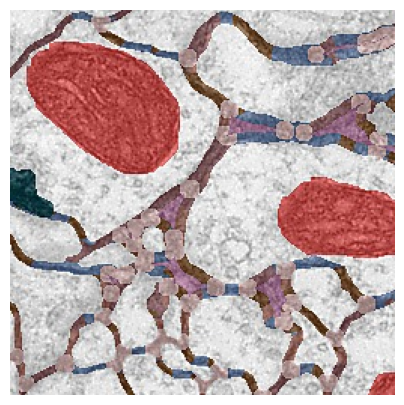

In [2]:
from PIL import Image
from urllib.request import urlopen
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

image_size = (256, 256)

url = 'https://s3-eu-west-1.amazonaws.com/pfigshare-u-previews/1288336/preview.jpg'

width = image_size[0]
height = image_size[1]
left = 100
top = 170

im_c = Image.open(urlopen(url)).crop((left,top,left + width, top + height))

from style_transfer import plot_example
plot_example(im_c)

We'll use the style of the _trencadis_ lizard by Antoni Gaudi  in Parc Guell (Barcelona)

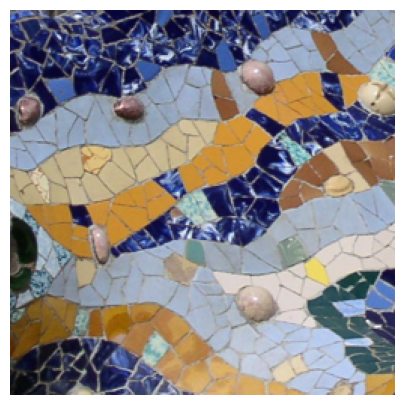

In [3]:
url = 'https://upload.wikimedia.org/wikipedia/commons/d/da/Reptil_Parc_Guell_Barcelona.jpg'

width = 512
height = 512
left = 800
top = 250

im_s = Image.open(urlopen(url)).crop((left,top,left + width, top + height)).resize(image_size)

plot_example(im_s)

We'll define a funtion for calculating the Gram matrix between all the features of a specific layer.

In [4]:
def gram_matrix(input):
    import torch
    b, c, h, w = input.size()
    F = input.view(b,c,h*w)
    G = torch.bmm(F, F.transpose(1,2))/(h*w)
    return G

We'll download a pretrained model (VGG16) and freeze all the weights.

In [5]:
import torchvision.models as models
model = models.vgg16(pretrained=True)

model.eval()
model.requires_grad_(False)

print(model)

/Users/841602/Documents/GitHub/Environments/deeplay_env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/841602/Documents/GitHub/Environments/deeplay_env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

The VGG16 is pretrained on the ImageNet dataset and the inputs are normalized wih respect to the mean and standard deviation of the channels of this dataset.

In [6]:
import numpy as np
mean_ds = np.array([0.485, 0.456, 0.406], dtype=np.float32)
std_ds = np.array([0.229, 0.224, 0.225], dtype=np.float32)

We'll define a function that minimize the style and content losses with respect to the reference images. 

In [7]:
def style_transfer(im_in, im_c, im_s, layers, ind_c, ind_s, lr = 1, beta = 1e3, num_iterations=100):

    import torch
    from style_transfer import fwd_hooks, preprocess, deprocess, plot_style
    import numpy as np
    from PIL import Image

    # content
    image_c = preprocess(im_c, mean_ds, std_ds)
    with fwd_hooks(layers) as fh:
        out = model(image_c)
    content_features = [fh.stored[i].detach() for i in ind_c]

    # style
    image_s = preprocess(im_s, mean_ds, std_ds)
    with fwd_hooks(layers) as fh:
        out = model(image_s)
    style_features = [fh.stored[i].detach() for i in ind_s]
    gram_targets = [gram_matrix(s) for s in style_features]

    #input
    try: im_in.verify()
    except: 
        print('Input image not provided. Using a random input.')
        imarray = np.random.rand(*image_size,3) * 255
        im_in = Image.fromarray(imarray.astype('uint8')).convert('RGB')
    
    image_in = preprocess(im_in, mean_ds, std_ds)#.requires_grad_(True)
    
    optimizer = torch.optim.LBFGS([image_in], lr = lr)
    mse_loss = torch.nn.MSELoss(reduction='sum')

    l_c = []
    l_s = []

    for it in range(num_iterations):
        def closure():
            optimizer.zero_grad()

            # content & style
            with fwd_hooks(layers) as fh:
                out = model(image_in)
            content_features_in = [fh.stored[i] for i in ind_c]
            style_features_in = [fh.stored[i] for i in ind_s]
            gram_in = [gram_matrix(i) for i in style_features_in]

            c_loss = 0
            for i,c in enumerate(content_features_in):
                n_f = c.shape[1]
                c_loss += mse_loss(c,content_features[i])/n_f**2
            c_loss /= len(content_features_in)

            s_loss = 0
            for i,g in enumerate(gram_in):
                n_g = g.shape[1]
                s_loss += mse_loss(g,gram_targets[i])/n_g**2
            s_loss /= len(gram_in)

            loss = c_loss + beta*s_loss
            l_c.append(c_loss)
            l_s.append(s_loss)

            loss.backward()
            return loss

        optimizer.step(closure)
        print('Step {}: Content Loss: {:.8f} Style Loss: {:.8f}'.format(it, l_c[-1], l_s[-1]))

        # if (it)%10 == 0:
        #     im_out = Image.fromarray(np.uint8(np.clip(deprocess(image_in.data.clone().detach(), mean_ds, std_ds)*255,0,255)), 'RGB') 
        #     plot_style(im_c, im_s, im_out)
    return Image.fromarray(np.uint8(np.clip(deprocess(image_in.data.clone(), mean_ds, std_ds)*255,0,255)), 'RGB')

We'll apply the style transfer using as an input the same image used to get the content.

Step 0: Content Loss: 218.97929382 Style Loss: 0.16353782
Step 1: Content Loss: 259.95745850 Style Loss: 0.08060105
Step 2: Content Loss: 280.48660278 Style Loss: 0.04512598
Step 3: Content Loss: 291.99041748 Style Loss: 0.03157575
Step 4: Content Loss: 297.08370972 Style Loss: 0.02496604
Step 5: Content Loss: 303.63980103 Style Loss: 0.01781984
Step 6: Content Loss: 306.56930542 Style Loss: 0.01444330
Step 7: Content Loss: 305.67108154 Style Loss: 0.01309988
Step 8: Content Loss: 307.57806396 Style Loss: 0.01039687
Step 9: Content Loss: 306.73507690 Style Loss: 0.00911481
Step 10: Content Loss: 304.53952026 Style Loss: 0.00835824
Step 11: Content Loss: 304.58001709 Style Loss: 0.00727709
Step 12: Content Loss: 303.63830566 Style Loss: 0.00657159
Step 13: Content Loss: 301.26132202 Style Loss: 0.00620194
Step 14: Content Loss: 300.91003418 Style Loss: 0.00544499
Step 15: Content Loss: 299.05014038 Style Loss: 0.00495482
Step 16: Content Loss: 297.31405640 Style Loss: 0.00449719
Step 17

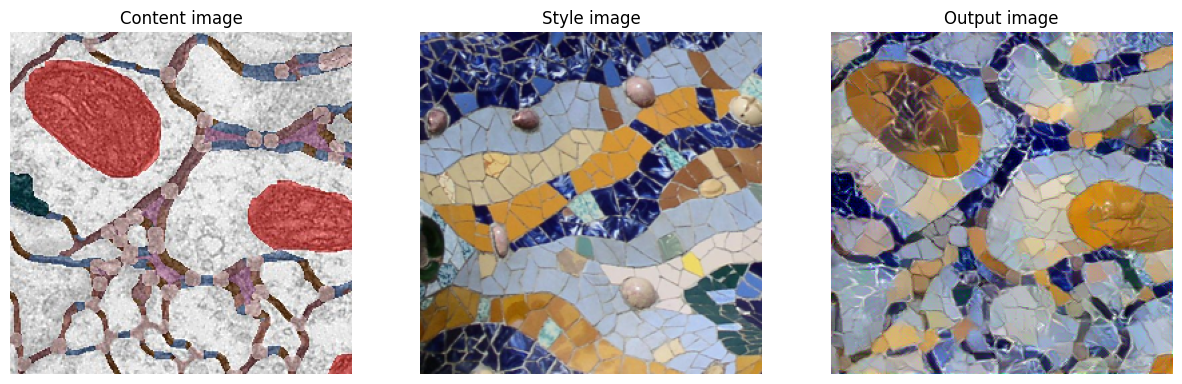

In [8]:
from style_transfer import plot_style

ind = [0, 2, 5, 7, 10, 14]
layers = [model.features[i] for i in ind ] 
ind_c = [5]
ind_s = [0, 1, 2, 3, 4]

im_out  =  style_transfer(im_c, im_c, im_s, layers, ind_c, ind_s, lr = 1, beta = 1e5, num_iterations=50)
plot_style(im_c, im_s, im_out)

We'll also apply the style transfer using as an input a random image.

Input image not provided. Using a random input.
Step 0: Content Loss: 495.79150391 Style Loss: 0.36821720
Step 1: Content Loss: 492.97100830 Style Loss: 0.11643767
Step 2: Content Loss: 475.58236694 Style Loss: 0.06768034
Step 3: Content Loss: 458.03912354 Style Loss: 0.04480988
Step 4: Content Loss: 432.74719238 Style Loss: 0.03599561
Step 5: Content Loss: 421.41333008 Style Loss: 0.02594232
Step 6: Content Loss: 405.39434814 Style Loss: 0.02144713
Step 7: Content Loss: 387.27526855 Style Loss: 0.01909257
Step 8: Content Loss: 377.35464478 Style Loss: 0.01605884
Step 9: Content Loss: 364.21450806 Style Loss: 0.01428918
Step 10: Content Loss: 350.85244751 Style Loss: 0.01299715
Step 11: Content Loss: 338.97579956 Style Loss: 0.01181190
Step 12: Content Loss: 329.44976807 Style Loss: 0.01102022
Step 13: Content Loss: 319.08129883 Style Loss: 0.01022870
Step 14: Content Loss: 310.35040283 Style Loss: 0.00959690
Step 15: Content Loss: 301.91043091 Style Loss: 0.00901570
Step 16: Content L

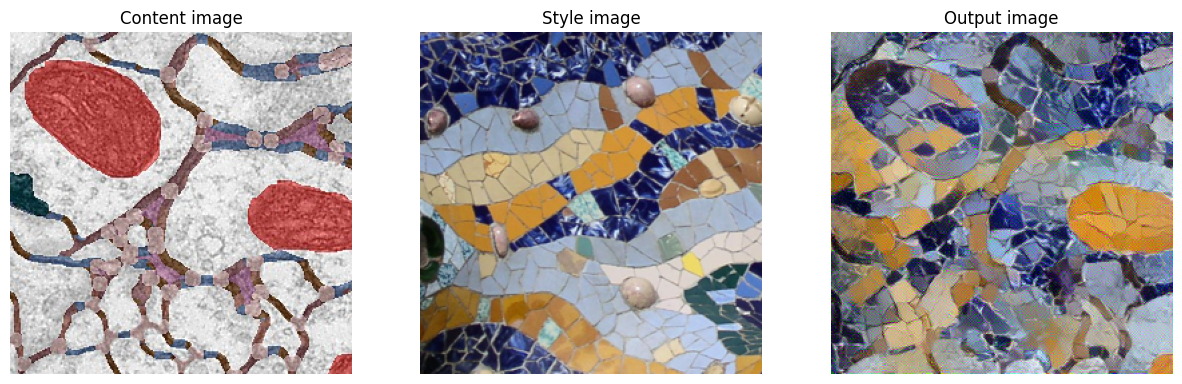

In [12]:
im_out  =  style_transfer([],im_c, im_s, layers, ind_c, ind_s, lr = 1, beta = 1e4, num_iterations=200)
plot_style(im_c, im_s, im_out)